In [ ]:
!pip install vncorenlp
!mkdir -p vncorenlp/models/wordsegmenter
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/wordsegmenter.rdr
!mv VnCoreNLP-1.1.1.jar vncorenlp/
!mv vi-vocab vncorenlp/models/wordsegmenter/
!mv wordsegmenter.rdr vncorenlp/models/wordsegmenter/


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 22.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for vncorenlp: filename=vncorenlp-1.0.3-py3-none-any.whl size=2645932 sha256=f1cb1caa704b85ff36d8e561606d87223091fe111cdc1a2c633688e729144536
  Stored in directory: /root/.cache/pip/wheels/5d/d9/b3/41f6c6b1ab758561fd4aab55dc0480b9d7a131c6aaa573a3fa
Successfully built vncorenlp
--2025-01-14 01:58:15--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27412575 (26M) [application/octet-stream]
Saving to: ‘VnCoreNLP-1.1.1.jar’

VnCoreNLP-1.1.1.jar 100%[===================>]  26.14M  49.3MB/s    in 0.5s    

2025-01-14 01:58:17 (49.3 MB/s) - ‘VnCoreNL

In [ ]:
#Import libraries
import pandas as pd
import numpy as np
import re
import seaborn as sns
from gensim.parsing.preprocessing import strip_non_alphanum, strip_multiple_whitespaces,preprocess_string, split_alphanum, strip_short, strip_numeric

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,confusion_matrix
import joblib
from vncorenlp import VnCoreNLP
from sklearn.metrics import classification_report, accuracy_score


In [ ]:
# Khởi tạo VnCoreNLP
vncorenlp = VnCoreNLP("vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx500m')
rdrsegmenter = VnCoreNLP("vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx2g')

In [ ]:
# Load datasets
train_data = pd.read_csv('train_data.csv')

In [ ]:
train_data

,Email,Label
0,NaN,1
1,NaN,0
2,"Xin chào Huỳnh Đô ꪜ,\n\nBùi Duy Tân đã gửi một...",0
3,[QC] Galaxy Z Series mới chính thức ra mắt!\n\...,1
4,Cảm ơn Quý khách đã sử dụng dịch vụ MB eBankin...,0
...,...,...
6320,Google Play\n\n\n\n\n\nCảm ơn bạn\n\n\n\n\n\nB...,0
6321,"Xin chào Huỳnh Đô ꪜ,\n\nĐào Thị Phương Anh, Ng...",0
6322,"Xin chào Huỳnh Đô ꪜ,\n\nLê Xuân Phước, Nguyễn ...",0
6323,Chào \nNguyễn Bá Thành\n\n\n\n\n\n\n\n\n\n\nCa...,0


In [ ]:
spam=train_data[train_data['Label']==1]

In [ ]:
ham=train_data[train_data['Label']==0]

In [ ]:
spam

,Email,Label
0,NaN,1
3,[QC] Galaxy Z Series mới chính thức ra mắt!\n\...,1
5,“Bí kíp” chi tiêu thỏa thích với E-voucher Vin...,1
7,"Từ Ngày 1 Tháng 12 2022, khi đăng nhập, người ...",1
8,Tuần lễ Galaxy 03.03 - 10.03\n\n\n\n\n\n\n\n\n...,1
...,...,...
6306,"Những việc làm IT mới nhất trên TopDev, khám p...",1
6307,[ View in browser](https://r.cskh.cellphones.c...,1
6308,Đừng bỏ qua các cơ hội việc làm hấp dẫn sắp hế...,1
6316,BỘ GIÁO DỤC VÀ ĐÀO TẠO\n\n\nKỲ THI TỐT NGHIỆP ...,1


<Axes: xlabel='Label', ylabel='count'>

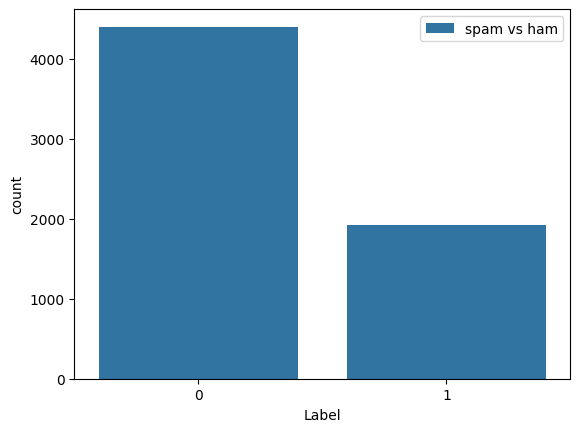

In [ ]:
sns.countplot(x='Label', data=train_data, label='spam vs ham')

In [ ]:
# Loại bỏ các dòng bị thiếu giá trị
train_data = train_data.dropna(subset=['Email', 'Label'])
# Tự định nghĩa stopwords tiếng Việt
vietnamese_stopwords = set(["và", "là", "của", "có", "một", "với", "cho", "được", "như", "này", "ở", "trên", "bằng"])
def clean_text(text):
    # Loại bỏ URL
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    # Loại bỏ ký tự đặc biệt
    text = re.sub(r'\W', ' ', text)
    # Loại bỏ số
    text = re.sub(r'\d', '', text)
    # Loại bỏ khoảng trắng thừa
    text = re.sub(r'\s+', ' ', text).strip()
    text = strip_non_alphanum(text).lower().strip()
    text = split_alphanum(text)
    return text

def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in vietnamese_stopwords])

# Áp dụng hàm làm sạch cho dữ liệu
train_data['Email'] = train_data['Email'].apply(clean_text)

# Loại bỏ các mẫu trùng lặp
train_data = train_data.drop_duplicates()
# Áp dụng
train_data['Email'] = train_data['Email'].apply(remove_stopwords)

<ipython-input-10-32bafce245cf>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Email'] = train_data['Email'].apply(clean_text)


In [ ]:
def word_segmentation(text):
    # Tách từ bằng VNCoreNLP
    segmented_text = rdrsegmenter.tokenize(text)

    # Ghép lại thành chuỗi
    return ' '.join([' '.join(sentence) for sentence in segmented_text])

def extract_compound_words(segmented_text):
    tokens = segmented_text.split()
    compound_words = []
    for i in range(len(tokens) - 1):
      compound_words.append(tokens[i] + " " + tokens[i+1])
    return compound_words

In [ ]:
print(train_data.head())

                                               Email  Label
2  xin chào huỳnh đô ꪜ bùi duy tân đã gửi tin nhắ...      0
3  qc galaxy z series mới chính thức ra mắt đặt t...      1
4  cảm ơn quý khách đã sử dụng dịch vụ mb ebankin...      0
5  bí kíp chi tiêu thỏa thích e voucher vinid tri...      1
6  xin chào huỳnh đô ꪜ trần thị hồng nhung phạm k...      0


In [ ]:
# Lưu dữ liệu đã xử lý
train_data.to_csv('train_final.csv', index=False)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer=CountVectorizer()
spamham_countVectorizer=vectorizer.fit_transform(train_data['Email'])

In [ ]:
print(vectorizer.get_feature_names_out())
print(len(vectorizer.get_feature_names_out()))

['__' '___' '_____' ... '𝙱𝚛𝚘𝚔𝚎𝚗' '𝙷𝚎𝚊𝚛𝚝' '𝙺𝙻']
12727


In [ ]:
spamham_countVectorizer.shape

(4637, 12727)

In [ ]:
label=train_data['Label']
X=spamham_countVectorizer
y=label

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

In [ ]:
from sklearn.naive_bayes import MultinomialNB

In [ ]:
NB_classifier=MultinomialNB()
NB_classifier.fit(X_train,y_train)

MultinomialNB()

In [ ]:
y_predict_train=NB_classifier.predict(X_train)
#y_predict_train

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
cm=confusion_matrix(y_train,y_predict_train)

<Axes: >

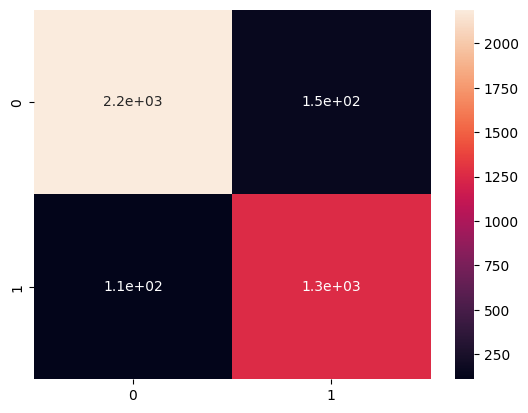

In [ ]:
sns.heatmap(cm,annot=True)

In [ ]:
y_predict_train=NB_classifier.predict(X_train)
# Predict on the test set to get y_predict_test
y_predict_test = NB_classifier.predict(X_test)
cm1=confusion_matrix(y_test,y_predict_test)

In [ ]:
print(classification_report(y_train,y_predict_train))
# Tính accuracy riêng
accuracy = accuracy_score(y_train, y_predict_train)
print(f"Accuracy: {accuracy:.2f}")


              precision    recall  f1-score   support

           0       0.95      0.94      0.94      2340
           1       0.89      0.92      0.91      1369

    accuracy                           0.93      3709
   macro avg       0.92      0.93      0.93      3709
weighted avg       0.93      0.93      0.93      3709

Accuracy: 0.93


In [ ]:
y_predict_test=NB_classifier.predict(X_test)
y_predict_test

array([0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1,

<Axes: >

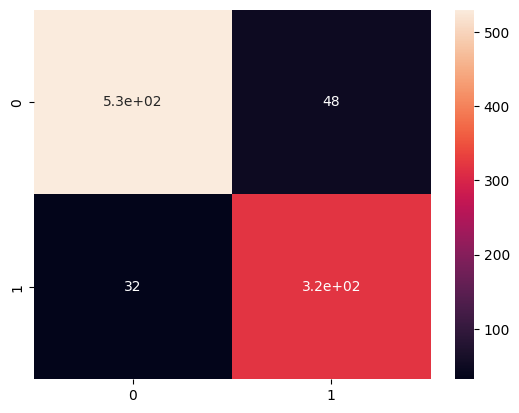

In [ ]:
sns.heatmap(cm1,annot=True)

In [ ]:
# Báo cáo chi tiết
print(classification_report(y_test, y_predict_test))

# Tính accuracy riêng
accuracy = accuracy_score(y_test, y_predict_test)
print(f"Accuracy: {accuracy:.2f}")


              precision    recall  f1-score   support

           0       0.94      0.92      0.93       578
           1       0.87      0.91      0.89       350

    accuracy                           0.91       928
   macro avg       0.91      0.91      0.91       928
weighted avg       0.92      0.91      0.91       928

Accuracy: 0.91


In [ ]:
import joblib

# Lưu vectorizer
joblib.dump(vectorizer, 'count_vectorizer.pkl')
joblib.dump(NB_classifier, 'naive_bayes_model.pkl')

['naive_bayes_model.pkl']

In [ ]:
# Dự đoán trên tập dữ liệu mới
new_data = vectorizer.transform(["Tôi là hiển"])
prediction = NB_classifier.predict(new_data)




print("Kết quả dự đoán:", "Spam" if prediction[0] == 1 else "Not Spam")

Kết quả dự đoán: Not Spam
